# Parcial 2

## Clasificación de partido político que pertenece un perfil de políticos españoles segun tweets

### José Manuel Montes Contreras  | 
_T00041911_

## Hipótesis

Pregunta de investigacion:
    ¿Es posible conocer a que partido pertenece un persona analizando lo que tweetea?

Hipótesis: se puede clasificar a qué partido politico pertenece una persona mediante el análisis de texto (tweets) y/o algoritmos de machine learning

## Librerias e importación de datos

In [149]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, recall_score, log_loss
from sklearn.metrics import f1_score, accuracy_score, precision_score

In [50]:
df = pd.read_csv('tweets_politica.csv', sep=';', engine='python')
df.head()

,ï»¿cuenta,partido,timestamp,tweet
0,a34133350b0605cb24081843f63176ca,psoe,13639734920,@vesteve3 @manubenas @ccoo_rm @desobediencia_ ...
1,a34133350b0605cb24081843f63176ca,psoe,13640610350,"â€œ@kirovast: @Hugo_Moran muy fan de la ""radic..."
2,a34133350b0605cb24081843f63176ca,psoe,13641168040,@ALTAS_PRESIONES Nuevos dueÃ±os para las renov...
3,a34133350b0605cb24081843f63176ca,psoe,13641209670,@jumanjisolar @solartradex @josea_dolera El di...
4,a34133350b0605cb24081843f63176ca,psoe,13641526920,â€œ@cesarnayu: https://t.co/J4OTXj1x7w â€¦ Por...


## Análisis Descriptivo

### Tipos de datos

In [51]:
df.dtypes

ï»¿cuenta    object
partido      object
timestamp     int64
tweet        object
dtype: object

### Datos faltantes / nulos

In [52]:
df.isna().sum().sort_values()

ï»¿cuenta    0
partido      0
timestamp    0
tweet        0
dtype: int64

### Balanceo de datos

In [55]:
#Calculamos la cantidad de datos que tiene cada partido (personas que pertenecen)
vc = df['partido']
unique_elements, counts_elements = np.unique(vc, return_counts=True)
vcc = np.asarray((unique_elements, counts_elements))
for i, j in zip(unique_elements, counts_elements):
    print(i,'=', j)

ciudadanos = 23552
podemos = 24889
pp = 26200
psoe = 28882
vox = 26506


In [56]:
#Calculamos el porcentaje de datos (políticos) por partido
for i, j in zip(unique_elements, counts_elements):
    j= round(j/130029*100, 2)
    print(i,'=', j,'%')

ciudadanos = 18.11 %
podemos = 19.14 %
pp = 20.15 %
psoe = 22.21 %
vox = 20.38 %


<BarContainer object of 5 artists>

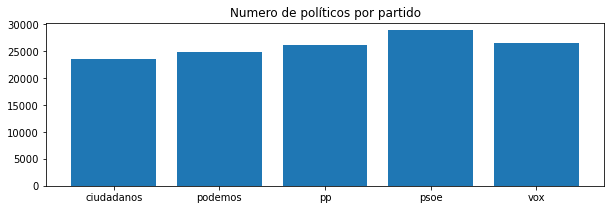

In [57]:
plt.figure(figsize=(10,3))
plt.title("Numero de políticos por partido")
plt.bar(unique_elements, counts_elements, )

Podemos observar que los datos se encuentran relativamente balanceados

## Datos de prueba y entrenamiento

In [11]:
X = np.asarray(df.drop(['partido'],1))

In [58]:
y = np.asarray(df['partido'])

In [59]:
#Dividimos los datos de prueba y entrenamiento de forma aleatoria
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop('partido', axis = 'columns'),
                                        df['partido'],
                                        train_size   = 0.8,
                                       
                                        shuffle      = True
                                    )

In [60]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(104023, 3) (26006, 3) (104023,) (26006,)


In [65]:
#Balanceamos la cantidad de datos para prueba y entrenamiento con RandomOverSampler
ros_train = RandomOverSampler(random_state=1000)
X_train, y_train = ros_train.fit_resample(X_train, y_train)
print('train:', sorted(Counter(y_train).items()))

train: [('ciudadanos', 23077), ('podemos', 23077), ('pp', 23077), ('psoe', 23077), ('vox', 23077)]


In [66]:
ros_test = RandomOverSampler(random_state=1000)
X_test, y_test = ros_test.fit_resample(X_test, y_test)
print('test:', sorted(Counter(y_test).items()))

test: [('ciudadanos', 5805), ('podemos', 5805), ('pp', 5805), ('psoe', 5805), ('vox', 5805)]


In [128]:
k_fold = ShuffleSplit(n_splits=10, test_size=0.20, random_state=42)

## Modelo BoW

In [95]:
bow = CountVectorizer(ngram_range=(1, 1))

## Modelo N-gram

In [100]:
def basic_clean(tweet):

  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('spanish')
  text = (unicodedata.normalize('NFKD', tweet)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', tweet).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [101]:
df['tweet']

0         @vesteve3 @manubenas @ccoo_rm @desobediencia_ ...
1         â€œ@kirovast: @Hugo_Moran muy fan de la "radic...
2         @ALTAS_PRESIONES Nuevos dueÃ±os para las renov...
3         @jumanjisolar @solartradex @josea_dolera El di...
4         â€œ@cesarnayu: https://t.co/J4OTXj1x7w â€¦ Por...
                                ...                        
130024    QuÃ© maravilla, visitar #LaRioja en #vendimiað...
130025    â€œQuerido Pablo, nos complace tu voluntad de ...
130026    Quiero reivindicar la buena polÃ­tica, la de f...
130027    ðŸ™‹ðŸ�»â€�â™€ï¸�El pasado viernes se cumpliÃ³...
130028    â€œPara nosotros la cuestiÃ³n no es Europa sÃ­...
Name: tweet, Length: 130029, dtype: object

In [102]:
words = basic_clean(''.join(str(df['tweet'].tolist())))

In [116]:
words

['vesteve3',
 'manubenas',
 'ccoo_rm',
 'desobediencia_',
 'ccoo',
 'emparempar',
 'Buen',
 'Ãnimo',
 'primavera',
 'iniciamos',
 'âœkirovast',
 'Hugo_Moran',
 'fan',
 'radicalidad',
 'socialâ',
 'Frente',
 'devaluaciÃ³n',
 'democrÃtica',
 'ALTAS_PRESIONES',
 'Nuevos',
 'dueÃos',
 'renovables',
 'En',
 'momento',
 'serÃn',
 'problema',
 'sino',
 'apuesta',
 'magnÃxadfica',
 'jumanjisolar',
 'solartradex',
 'josea_dolera',
 'El',
 'diferencial',
 'precios',
 'energÃticos',
 'Alemania',
 'Francia',
 'sigue',
 'siendo',
 'mismo',
 '811',
 'âMWh',
 'âœcesarnayu',
 'httpstcoJ4OTXj1x7w',
 'â',
 'Por',
 'favor',
 'importante',
 'difundir',
 'mensaje',
 'concienciar',
 'Â',
 'puedes',
 'retwittear',
 'Hecho',
 'âœiAgua',
 'httptco6yMSNcV1UAâ',
 'El',
 'Gobierno',
 'sigue',
 'adelante',
 'plane',
 'privatizaciÃ³n',
 'hidrolÃ³gica',
 'Cospedal',
 'crisis',
 'afectan',
 'EspaÃa',
 'Guindos',
 'si',
 'resuelve',
 'crisis',
 'Chipre',
 'puede',
 'contagiar',
 'EspaÃa',
 'âœventonoso',
 'EspaÃa',
 '

In [104]:
(pd.Series(nltk.ngrams(words,1)).value_counts())

(mÃs,)                        16952
(El,)                         15660
(ðŸ,)                         14738
(EspaÃa,)                     13150
(La,)                         13113
                              ...  
(VidalLeer,)                      1
(httpstcobCTnHmKWoh,)             1
(AgendaSocial,)                   1
(desatendiÃ³,)                    1
(administracionesGracias,)        1
Length: 316628, dtype: int64

In [106]:
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:12]

Text(0.5, 0, '# de incidencias')

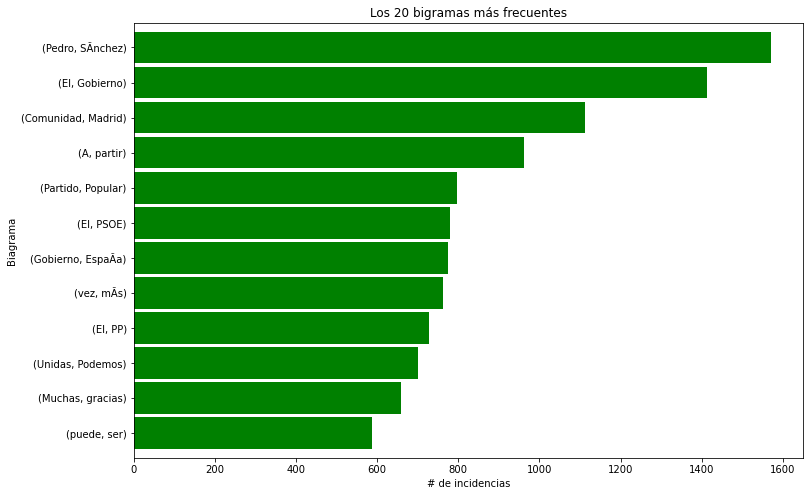

In [108]:
bigrams_series.sort_values().plot.barh(color='green', width=.9, figsize=(12, 8))
plt.title('Los 20 bigramas más frecuentes')
plt.ylabel('Biagrama')
plt.xlabel('# de incidencias')

In [176]:
softmax = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)